# AuxTel Electronic Gain 
## Dependence with the Readout Board Temperature

Created on: May 22th, 2022\
Author: Johnny Esteves

In [1]:
date = '22May22'
print(f'Created this code on {date}')

Created this code on 22May22


In [2]:
import sys, os, glob, time
import numpy as np
import pandas as pd
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler

In [3]:
df0 = pd.read_csv('data/flat_field_pairs_auxTel_2022.csv', index_col=0)
df0

,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
2022050500254,20220505,254,2022050500254,0.6,2022-05-05T21:06:41.184990,9356.223633,16.495535,0.000000,16.495535,0.000000
2022050500253,20220505,253,2022050500253,0.6,2022-05-05T21:06:35.608999,9355.787109,16.495535,0.000000,16.495535,0.000000
2022050500135,20220505,135,2022050500135,0.5,2022-05-05T20:22:20.176007,7796.404297,16.591160,0.104821,16.601613,0.105397
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008,7794.852539,12.767246,2.774818,12.777213,2.774804
2022050400139,20220504,139,2022050400139,0.6,2022-05-04T20:21:05.397012,8893.919922,15.892858,0.000000,15.915178,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021012100540,20210121,540,2021012100540,0.2,2021-01-21T21:15:31.416373,6242.013184,NaN,NaN,NaN,NaN
2021011900096,20210119,96,2021011900096,0.3,2021-01-19T21:03:36.458404,9585.971680,NaN,NaN,NaN,NaN
2021011900095,20210119,95,2021011900095,0.3,2021-01-19T21:03:33.611463,9586.920898,NaN,NaN,NaN,NaN
2021011900094,20210119,94,2021011900094,0.2,2021-01-19T21:03:30.767340,6393.916992,NaN,NaN,NaN,NaN


In [4]:
# df0.time.dt.hour

In [5]:
flux_low, flux_high = 5000, 10000
flux_mask = (df0.Flux>flux_low)&(df0.Flux<flux_high)

temp_nan = np.isnan(df0.Temp1)

good = flux_mask&(~temp_nan)

print(f'Number of Good Exposures {np.count_nonzero(good)}')
print(f'Number of Good Pairs {np.count_nonzero(good)/2}')

Number of Good Exposures 40
Number of Good Pairs 20.0


In [6]:
df_all = df0[good].to_numpy().T
exps = df_all[2].astype(int)
days_vec = df_all[0]
seq_num = df_all[1].astype(int)
exp_time = df_all[3].astype(float)
times = df_all[4]
flux = df_all[5].astype(float)
temp = df_all[6].astype(float)
tempErr = df_all[7].astype(float)

In [7]:
days = list(np.unique(days_vec))
print('days:',days)

days: [20220224, 20220405, 20220406, 20220503, 20220504, 20220505]


In [8]:
data_list = []
for day in days:
    print(f"Collection: u/jesteves/latiss/ptc_tREB_rerun_{day}")
    butleri = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib", 
                                                          f"u/jesteves/latiss/ptc_tREB_rerun_{day}"])
    data = dict()
    data['butler'] = butleri
    data['indices'] = np.where(day==days_vec)[0]
    data_list.append(data)

Collection: u/jesteves/latiss/ptc_tREB_rerun_20220224
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220405
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220406
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220503
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220504
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220505


In [9]:
for day,data in zip(days,data_list):
    data['day'] = day
    butler = data['butler']
    indices = data['indices'][:]
    data['exposures'] = exps[data['indices'][:]]
    data['temperatures'] = temp[data['indices'][:]]
    data['temperatures_err'] = tempErr[data['indices'][:]]
    data['flux'] = flux[data['indices'][:]]
    data['exp_time'] = exp_time[data['indices'][:]]
    
    pair_list = list(data['exposures'])
    
    res1, res2 = [], []
    for exp in pair_list:
        ptcDataset = cpCovs = butler.get('cpCovariances', exposure=exp, detector=0, instrument='LATISS')
        gain_data = ptcDataset.gain
        gain_err_data = ptcDataset.gainErr
        amps = gain_data.keys()
        gains = []
        gain_err = []
        amp_nums = []
        for ii, amp in enumerate(amps):
            gains.append(gain_data[amp])
            gain_err.append(gain_err_data[amp])
            amp_nums.append(ii)
        res1.append(np.median(gains))
        res2.append(np.median(gain_err))
    
    data['gain'] = np.where(np.array(res1)==0,np.nan,res1)
    data['gainErr'] = np.sqrt(np.array(res2)**2 + np.nanstd(data['gain'])**2)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

Text(0, 0.5, 'Rel. Gain Change')

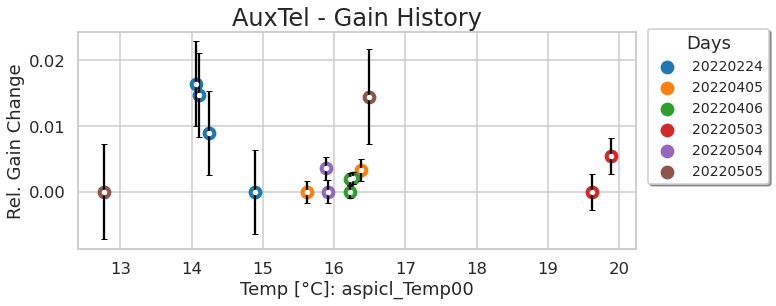

In [11]:
plt.figure(figsize=(10,4))
plt.title("AuxTel - Gain History", fontsize=24)
for day,data in zip(days,data_list):
    gains = data['gain']
    gain_err = data['gainErr']
    temp = data['temperatures']
    temp_err = data['temperatures_err']
    rel_gain = gains-np.nanmin(gains)
    plt.scatter(temp, rel_gain, label=day, s=150)
    plt.errorbar(temp, rel_gain, yerr=gain_err,
             fmt='.w',capsize=3,ecolor='k')
plt.legend(fontsize=14, loc=(1.02,.3), 
           ncol=1, shadow=True, title="Days", fancybox=True)
plt.xlabel('Temp [°C]: aspicl_Temp00')
plt.ylabel('Rel. Gain Change')

Text(0, 0.5, 'Rel. Gain Change')

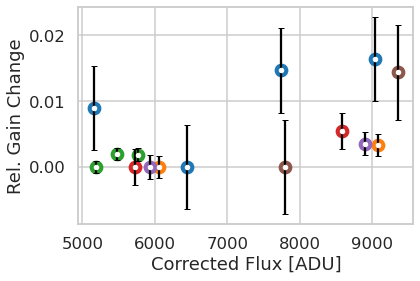

In [12]:
for day,data in zip(days,data_list):
    gains = data['gain']
    gain_err = data['gainErr']
    temp = data['temperatures']
    temp_err = data['temperatures_err']
    rel_gain = gains-np.nanmin(gains)
    flux = data['flux']
    plt.scatter(flux, rel_gain, label=day, s=150)
    plt.errorbar(flux, rel_gain, yerr=gain_err,
             fmt='.w',capsize=3,ecolor='k')
# plt.legend(fontsize=14, loc=(1.02,.3), 
#            ncol=1, shadow=True, title="Days", fancybox=True)

plt.xlabel('Corrected Flux [ADU]')
plt.ylabel('Rel. Gain Change')

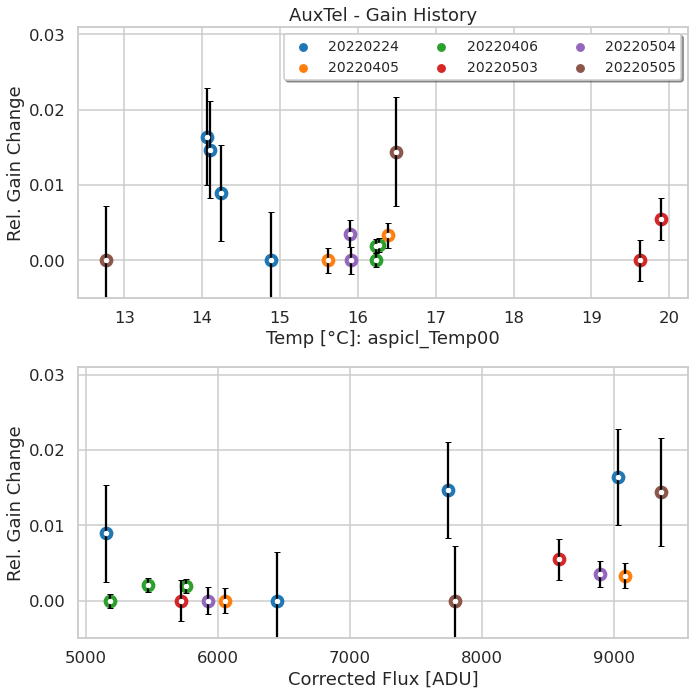

In [13]:
fig, ax = plt.subplots(2, 1, sharey='col', figsize=(10,10))
# fig.suptitle("AuxTel - Gain History", fontsize=24)
fig.subplots_adjust(hspace=0.3)
for day,data in zip(days,data_list):
    gains = data['gain']
    gain_err = data['gainErr']
    temp = data['temperatures']
    temp_err = data['temperatures_err']
    rel_gain = gains-np.nanmin(gains)
    ax[0].scatter(temp, rel_gain, label=day, s=150)
    ax[0].errorbar(temp, rel_gain, yerr=gain_err,
             fmt='.w',capsize=3,ecolor='k')
    
    flux = data['flux']
    ax[1].scatter(flux, rel_gain, label=day, s=150)
    ax[1].errorbar(flux, rel_gain, yerr=gain_err,
             fmt='.w',capsize=3,ecolor='k')

ax[0].set_ylim(-0.005, 0.031)
ax[0].legend(fontsize=14, markerscale=0.6,
           ncol=3, shadow=True,fancybox=True)

ax[0].set_yticks(np.arange(0, 0.03+0.01, 0.01))
ax[0].set_title("AuxTel - Gain History", fontsize=18)
ax[0].set_xlabel('Temp [°C]: aspicl_Temp00')
ax[0].set_ylabel('Rel. Gain Change')
ax[1].set_ylabel('Rel. Gain Change')
ax[1].set_xlabel('Corrected Flux [ADU]')
fig.tight_layout()
fig.savefig(f'./plots/temp_rel_gain_pannel_May22.pdf',dpi=100)

Text(0, 0.5, 'Exposure Time [sec]')

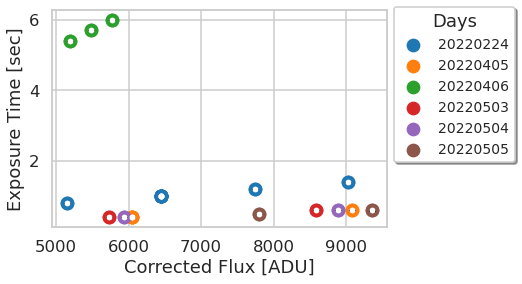

In [14]:
for day,data in zip(days,data_list):
    gains = data['gain']
    gain_err = data['gainErr']
    temp = data['temperatures']
    temp_err = data['temperatures_err']
    rel_gain = gains-np.nanmin(gains)
    flux = data['flux']
    exp_time = data['exp_time']
    plt.scatter(flux, exp_time, label=day, s=150)
    plt.errorbar(flux, exp_time, yerr=gain_err,
             fmt='.w',capsize=3,ecolor='k')
plt.legend(fontsize=14, loc=(1.02,.3), 
           ncol=1, shadow=True, title="Days", fancybox=True)

plt.xlabel('Corrected Flux [ADU]')
plt.ylabel('Exposure Time [sec]')

In [15]:
for day,data in zip(days,data_list):
    gains = data['gain']
    exposures = data['flux']
    print(data['day'])
    print(gains)
    print(exposures)
    print('\n')

20220224
[       nan 1.07355711        nan 1.07181443        nan        nan
        nan 1.06606231        nan        nan        nan        nan
        nan        nan        nan 1.05714034]
[9034.64550781 9034.6015625  7741.68115234 7742.02734375 6448.96826172
 6448.63232422 5156.6640625  5156.03515625 6449.07714844 6449.05908203
 6448.99560547 6448.49951172 6449.24267578 6448.49609375 6448.86523438
 6448.22949219]


20220405
[       nan        nan        nan 1.06654276        nan 1.06324299]
[6051.65966797 6052.68457031 9083.89550781 9084.23632812 6053.19238281
 6053.73046875]


20220406
[       nan 1.06982667        nan 1.06995834        nan 1.06792946]
[5764.81738281 5764.44287109 5476.07714844 5475.69140625 5186.16259766
 5186.47363281]


20220503
[       nan 1.07147794        nan 1.06599409]
[8583.58691406 8583.51269531 5723.56982422 5723.87792969]


20220504
[       nan 1.06615588        nan 1.06261478]
[8893.91992188 8893.79003906 5930.1015625  5930.24072266]


20220505
[       n